In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PolyCollection
import neuron
from neuron import h
import numba
import time, os
import subprocess
import pickle, glob
import scipy
import h5py

# 1. Find the electric field information of the 10 nearest points around each cell, and perform linear interpolation on the extracellular electric field of neurons.

In [62]:
def interpolate_field_ofCellSecAndSeg(sectionCoords, segmentCoords, E_position, E_vector, method='section', numClosedPoints=10, outlier_threshold=2.0):
    # inputs - coords: (num_sec/num_seg, 3) unit is mm
    # inputs - E_position: (num_nodes, 3) unit is mm
    # inputs - E_vector: (num_nodes, 3) unit is V/m or mV/mm
    '''
    # (1) Find the 10 closest nodes around the cell
    num_section = sectionCoords.shape[0]
    num_segment = segmentCoords.shape[0]
    if method == 'segment':
        indices_10closed_points_around_cell = np.zeros((num_segment, numClosedPoints))
        for i in range(num_segment):
            distance = E_position - segmentCoords[i]
            distance = np.linalg.norm(distance, axis=1)
            indices_10closed_points_around_cell[i, :] = np.argsort(distance)[:numClosedPoints]
    elif method == 'section':
        # as the same with matlab function knnsearch(E_position, sectionCoords[i],'k',10),
        # but the matlab code run very fast than python code
        indices_10closed_points_around_cell = np.zeros((num_section, numClosedPoints))
        for i in range(num_section):
            distance = E_position - sectionCoords[i]
            distance = np.linalg.norm(distance, axis=1)
            indices_10closed_points_around_cell[i, :] = np.argsort(distance)[:numClosedPoints]
    unique_indices = np.unique(indices_10closed_points_around_cell).astype(int)
    nodes_near_cell = E_position[unique_indices, :]
    Evector_near_cell = E_vector[unique_indices, :]
    logical_indices_normal_Evector = exclude_outlier_Evector(Evector_near_cell, threshold=outlier_threshold)
    unique_indices = unique_indices[logical_indices_normal_Evector]
    nodes_near_cell = nodes_near_cell[logical_indices_normal_Evector, :]
    Evector_near_cell = Evector_near_cell[logical_indices_normal_Evector, :]
    '''
    numClosedPoints = 10
    while_flag = True
    while while_flag:
        unique_indices, nodes_near_cell, Evector_near_cell = find_closest_points_around_cell(sectionCoords, segmentCoords, \
                                                E_position, E_vector, method=method, numClosedPoints=numClosedPoints, outlier_threshold=outlier_threshold)
        Ex_interp = scipy.interpolate.griddata(nodes_near_cell, Evector_near_cell[:, 0], segmentCoords, method='linear')
        Ey_interp = scipy.interpolate.griddata(nodes_near_cell, Evector_near_cell[:, 1], segmentCoords, method='linear')
        Ez_interp = scipy.interpolate.griddata(nodes_near_cell, Evector_near_cell[:, 2], segmentCoords, method='linear')
        Einterp_segment = np.column_stack((Ex_interp, Ey_interp, Ez_interp))
        if np.any(np.isnan(Einterp_segment)):
            numClosedPoints += 5
        else:
            while_flag = False
            
    # (2) Interpolate the extracellular electric field vector for each section and segment of the neuron
    #     based on the closest nodes information around the cell
    # The results are the same with the matlab function: scatteredInterpolant
    Ex_interp = scipy.interpolate.griddata(nodes_near_cell, Evector_near_cell[:, 0], segmentCoords, method='linear')
    Ey_interp = scipy.interpolate.griddata(nodes_near_cell, Evector_near_cell[:, 1], segmentCoords, method='linear')
    Ez_interp = scipy.interpolate.griddata(nodes_near_cell, Evector_near_cell[:, 2], segmentCoords, method='linear')
    Einterp_segment = np.column_stack((Ex_interp, Ey_interp, Ez_interp))
    Ex_interp = scipy.interpolate.griddata(nodes_near_cell, Evector_near_cell[:, 0], sectionCoords, method='linear')
    Ey_interp = scipy.interpolate.griddata(nodes_near_cell, Evector_near_cell[:, 1], sectionCoords, method='linear')
    Ez_interp = scipy.interpolate.griddata(nodes_near_cell, Evector_near_cell[:, 2], sectionCoords, method='linear')
    Einterp_section = np.column_stack((Ex_interp, Ey_interp, Ez_interp))
    return Einterp_section, Einterp_segment, Evector_near_cell, nodes_near_cell, unique_indices


def find_closest_points_around_cell(sectionCoords, segmentCoords, E_position, E_vector, method='section', numClosedPoints=10, outlier_threshold=2.0):
    # (1) Find the 10 closest nodes around the cell
    num_section = sectionCoords.shape[0]
    num_segment = segmentCoords.shape[0]
    if method == 'segment':
        indices_10closed_points_around_cell = np.zeros((num_segment, numClosedPoints))
        for i in range(num_segment):
            distance = E_position - segmentCoords[i]
            distance = np.linalg.norm(distance, axis=1)
            indices_10closed_points_around_cell[i, :] = np.argsort(distance)[:numClosedPoints]
    elif method == 'section':
        # as the same with matlab function knnsearch(E_position, sectionCoords[i],'k',10),
        # but the matlab code run very fast than python code
        indices_10closed_points_around_cell = np.zeros((num_section, numClosedPoints))
        for i in range(num_section):
            distance = E_position - sectionCoords[i]
            distance = np.linalg.norm(distance, axis=1)
            indices_10closed_points_around_cell[i, :] = np.argsort(distance)[:numClosedPoints]
    unique_indices = np.unique(indices_10closed_points_around_cell).astype(int)
    nodes_near_cell = E_position[unique_indices, :]
    Evector_near_cell = E_vector[unique_indices, :]
    logical_indices_normal_Evector = exclude_outlier_Evector(Evector_near_cell, threshold=outlier_threshold)
    unique_indices = unique_indices[logical_indices_normal_Evector]
    nodes_near_cell = nodes_near_cell[logical_indices_normal_Evector, :]
    Evector_near_cell = Evector_near_cell[logical_indices_normal_Evector, :]
    return unique_indices, nodes_near_cell, Evector_near_cell


def exclude_outlier_Evector(Evector_near_cell, threshold=2.0):
    Emagn = np.linalg.norm(Evector_near_cell, axis=1)
    mean_Emag, std_Emag = np.mean(Emagn), np.std(Emagn)
    # calculate the z_score of each point
    z_scores = (Emagn - mean_Emag) / std_Emag
    logical_indices_exclude_outlier = np.abs(z_scores) < threshold
    return logical_indices_exclude_outlier

In [50]:
# (1) Load the electric field information of the ROI box area
dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\ROIBox_Evector.npy'
Efield_ROIBox = np.load(dataPath, allow_pickle=True).item()
print(Efield_ROIBox.keys())
E_position_node = Efield_ROIBox['E_position_node'] # shape=(nodes.nr, 3)
E_vector_node   = Efield_ROIBox['E_vector_node']   # shape=(nodes.nr, 3) 
# (2) Load the information of each cell in the cluster
dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_popCell_sectionAndSegmentCoordinates.npy'
popCellInfo = np.load(dataPath, allow_pickle=True).item()
sectionCoords_allCells = popCellInfo['popCells_section_coords']['section_coordinates_mid'] # shape = (num_elem, num_section, 3) = (1000,  780, 3)
segmentCoords_allCells = popCellInfo['popCells_segment_coords']['segment_coordinates_mid'] # shape = (num_elem, num_segment, 3) = (1000, 1808, 3)
cell_normals = popCellInfo['cell_normals']
cell_origins = popCellInfo['cell_origins']
num_element = sectionCoords_allCells.shape[0]
num_section = sectionCoords_allCells.shape[1]
num_segment = segmentCoords_allCells.shape[1]

dict_keys(['cube_range', 'E_position_elm', 'E_vector_elm', 'E_position_node', 'E_vector_node'])


In [93]:
# Please set to True
if False:
    # ####################################################################################### #
    # Set to True for run a complete simulation for 1000-cell population field interpolation. #
    # ####################################################################################### #
    # Simulation time is about ~1 hour for 1 cpu core.
    # Matlab code is time saved
    E_position, E_vector = E_position_node, E_vector_node
    popCell_Einterp_section = np.zeros((num_element, num_section, 3))
    popCell_Einterp_segment = np.zeros((num_element, num_segment, 3))
    popCell_nearEvector     = [None] * num_element
    popCell_nearNodes       = [None] * num_element
    popCell_nearNodes_indices = [None] * num_element
    for i in range(num_element):
        sectionCoords, segmentCoords = sectionCoords_allCells[i], segmentCoords_allCells[i]
        Einterp_section, Einterp_segment, Evector_near_cell, nodes_near_cell, nodes_near_cell_indices = interpolate_field_ofCellSecAndSeg( \
                           sectionCoords, segmentCoords, E_position, E_vector, method='section', numClosedPoints=10, outlier_threshold=2)
        popCell_Einterp_section[i, :, :] = Einterp_section
        popCell_Einterp_segment[i, :, :] = Einterp_segment
        popCell_nearEvector[i]           = Evector_near_cell
        popCell_nearNodes[i]             = nodes_near_cell
        popCell_nearNodes_indices[i]     = nodes_near_cell_indices
    data = {
        'popCell_Einterp_section': popCell_Einterp_section, # unit - mm
        'popCell_Einterp_segment': popCell_Einterp_segment, # unit - mm
        'popCell_nearEvector': popCell_nearEvector,         # unit - V/m
        'popCell_nearNodes': popCell_nearNodes,             # unit - mm
        'popCell_nearNodes_indices': popCell_nearNodes_indices }
    savePath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_popCell_interpolate_Evector_forSectionAndSegment_noNan.npy'
    if not os.path.exists(savePath):
        np.save(savePath, data)
if False:
    # ####################################################################################### #
    # Set to True for save the uniform Evector based on section/segment mean or soma compartment.
    # ####################################################################################### #
    dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_popCell_interpolate_Evector_forSectionAndSegment_noNan.npy'
    data = np.load(dataPath, allow_pickle=True).item()
    popCell_Einterp_section   = data['popCell_Einterp_section']
    popCell_Einterp_segment   = data['popCell_Einterp_segment']
    popCell_nearEvector       = data['popCell_nearEvector']
    popCell_nearNodes         = data['popCell_nearNodes']
    popCell_nearNodes_indices = data['popCell_nearNodes_indices']

    uniformEvector_by_soma = np.zeros((num_element, 3))
    uniformEvector_by_sectionMean = np.zeros((num_element, 3))
    uniformEvector_by_segmentMean = np.zeros((num_element, 3))
    point_in_or_out_of_cortex = np.zeros(num_element) + 1
    for i in range(num_element):
        uniformEvector_by_soma[i, :]        = popCell_Einterp_section[i][0, :]
        # meanEvec_section = np.mean(popCell_Einterp_section[i], axis=0)
        # meanEvec_segment = np.mean(popCell_Einterp_segment[i], axis=0)
        uniformEvector_by_sectionMean[i, :] = np.mean(popCell_Einterp_section[i], axis=0)
        uniformEvector_by_segmentMean[i, :] = np.mean(popCell_Einterp_segment[i], axis=0)
        if np.dot(popCell_Einterp_section[i][0, :], cell_normals[i, :]) < 0:
            point_in_or_out_of_cortex[i] = -1
    uniformEmagnitude_by_soma        = np.linalg.norm(uniformEvector_by_soma, axis=1)
    uniformEmagnitude_by_sectionMean = np.linalg.norm(uniformEvector_by_sectionMean, axis=1)
    uniformEmagnitude_by_segmentMean = np.linalg.norm(uniformEvector_by_segmentMean, axis=1)
    data = {
        'uniformEvector_by_soma': uniformEvector_by_soma,
        'uniformEmagnitude_by_soma': uniformEmagnitude_by_soma,
        'uniformEvector_by_sectionMean': uniformEvector_by_sectionMean,
        'uniformEmagnitude_by_sectionMean': uniformEmagnitude_by_sectionMean,
        'uniformEvector_by_segmentMean': uniformEvector_by_segmentMean,
        'uniformEmagnitude_by_segmentMean': uniformEmagnitude_by_segmentMean,
        'point_in_or_out_of_cortex': point_in_or_out_of_cortex,
        'cell_normals': cell_normals,
        'cell_origins': cell_origins, 
        'num_element': num_element
    }
    savePath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_popCell_uniformEfiel_bySomaSectionSegment.mat'
    if not os.path.exists(savePath):
        scipy.io.savemat(savePath, data)

# 2. Draw the electric field information of the nearest nodes around the cell

In [14]:
dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_popCell_interpolate_Evector_forSectionAndSegment_test.npy'
data = np.load(dataPath, allow_pickle=True).item()
indices = [475, 483, 531, 474, 529, 481, 473, 480, 472, 528]
popCell_Einterp_section   = data['popCell_Einterp_section']
popCell_Einterp_segment   = data['popCell_Einterp_segment']
popCell_nearEvector       = data['popCell_nearEvector']
popCell_nearNodes         = data['popCell_nearNodes']
popCell_nearNodes_indices = data['popCell_nearNodes_indices']

dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_popInformation.npy'
data = np.load(dataPath, allow_pickle=True).item()
Layer5_popPosition = data['Layer5_popPosition']

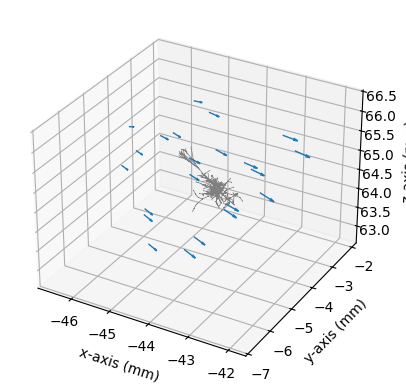

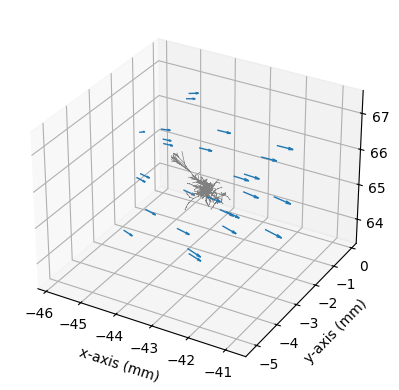

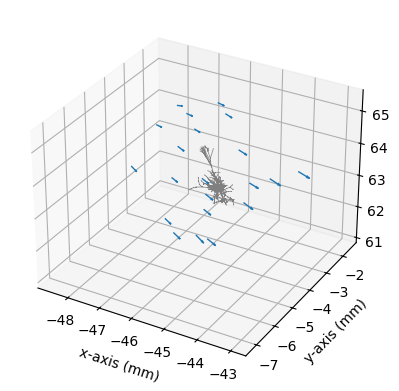

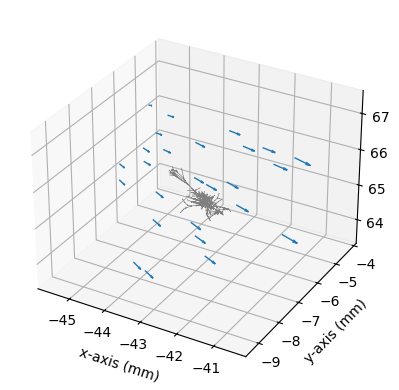

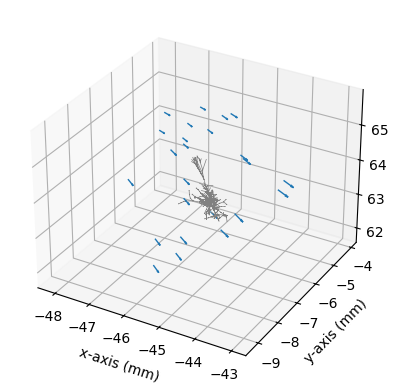

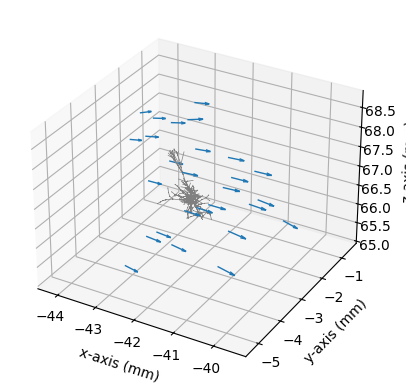

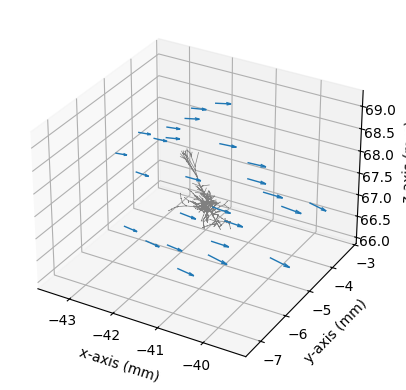

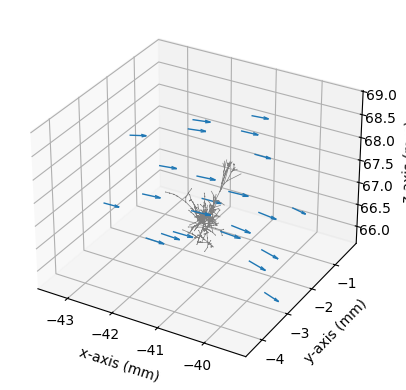

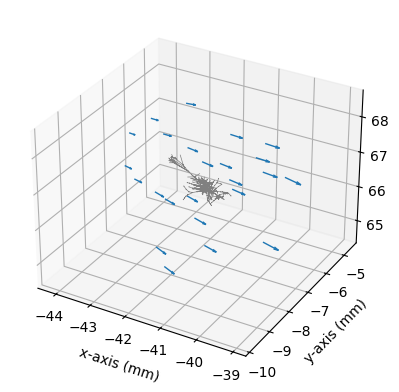

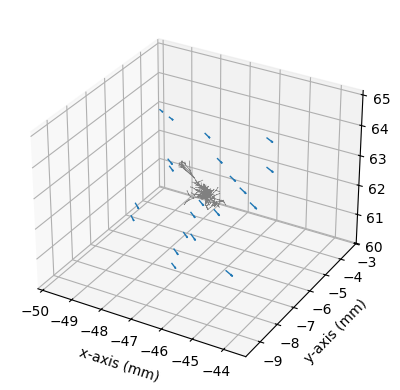

In [15]:
# for i in [473]:
for i in indices:
    fig = plt.figure(figsize=(4, 4))
    ax = fig.add_subplot(111, projection='3d')
    cell_coordinates = Layer5_popPosition[i]
    tempPosition  = popCell_nearNodes[i]
    tempDirection = np.array([popCell_nearEvector[i][j]/np.linalg.norm(popCell_nearEvector[i][j]) for j in range(popCell_nearEvector[i].shape[0])])
    tempLength    = np.linalg.norm(popCell_nearEvector[i], axis=1) * 1.
    ax.plot(cell_coordinates[0], cell_coordinates[1], cell_coordinates[2], lw=0.5, color='gray', zorder=5) 
    for k in range(popCell_nearEvector[i].shape[0]):
        ax.quiver(tempPosition[k,0], tempPosition[k,1], tempPosition[k,2], \
                  tempDirection[k,0], tempDirection[k,1], tempDirection[k,2], length=tempLength[k], lw=1)
    
    ax.axis('equal')
    # ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])
    ax.set_xlabel('x-axis (mm)', fontsize=10, labelpad=1)
    ax.set_ylabel('y-axis (mm)', fontsize=10, labelpad=1)
    ax.set_zlabel('z-axis (mm)', fontsize=10, labelpad=1)
    ax.tick_params(pad=0)
    plt.tight_layout()
    # ax.view_init(elev=0, azim=90)

# 3. Plot the interpolation results of the cell section/segment electric field (uniform - non-uniform)

In [21]:
dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_popCell_interpolate_Evector_forSectionAndSegment.npy'
data = np.load(dataPath, allow_pickle=True).item()
indices = [475, 473, 528]
popCell_Einterp_section   = data['popCell_Einterp_section']
popCell_Einterp_segment   = data['popCell_Einterp_segment']
popCell_nearEvector       = data['popCell_nearEvector']
popCell_nearNodes         = data['popCell_nearNodes']
popCell_nearNodes_indices = data['popCell_nearNodes_indices']

dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_popInformation.npy'
data = np.load(dataPath, allow_pickle=True).item()
Layer5_popPosition = data['Layer5_popPosition']

dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_popCell_sectionAndSegmentCoordinates.npy'
popCellInfo = np.load(dataPath, allow_pickle=True).item()
sectionCoords_allCells = popCellInfo['popCells_section_coords']['section_coordinates_mid'] # shape = (num_elem, num_section, 3) = (1000,  780, 3)
segmentCoords_allCells = popCellInfo['popCells_segment_coords']['segment_coordinates_mid'] # shape = (num_elem, num_segment, 3) = (1000, 1808, 3)

In [50]:
for i in range(len(indices)):
    Einterp_section = popCell_Einterp_section[indices[i]]
    Einterp_section_norm = np.linalg.norm(Einterp_section, axis=1)
    Einterp_segment = popCell_Einterp_segment[indices[i]]
    Einterp_segment_norm = np.linalg.norm(Einterp_segment, axis=1)
    print('Cell %d. Section interp mean field: %.6f V/m. Segment interp mean field: %.6f V/m. Soma interp field: %.6f V/m' \
          % (indices[i], np.mean(Einterp_section_norm), np.mean(Einterp_segment_norm), Einterp_section_norm[0]), \
          '\n         ', np.mean(Einterp_section, axis=0), '; ', np.mean(Einterp_segment, axis=0), '; ', Einterp_section[0], '. ')

Cell 475. Section interp mean field: 0.323722 V/m. Segment interp mean field: 0.317065 V/m. Soma interp field: 0.320138 V/m 
          [ 0.30660922 -0.00053401 -0.10363266] ;  [ 0.30085631 -0.00121793 -0.09974385] ;  [ 0.30373787 -0.00079242 -0.1011488 ] . 
Cell 473. Section interp mean field: 0.370552 V/m. Segment interp mean field: 0.365250 V/m. Soma interp field: 0.368274 V/m 
          [ 0.3628234   0.05156339 -0.05279406] ;  [ 0.3582317   0.05048343 -0.04725711] ;  [ 0.36115319  0.05255111 -0.04931667] . 
Cell 528. Section interp mean field: 0.244751 V/m. Segment interp mean field: 0.243413 V/m. Soma interp field: 0.244836 V/m 
          [ 0.21044291 -0.05508205 -0.11210319] ;  [ 0.20925642 -0.05547989 -0.11120084] ;  [ 0.21083555 -0.05497715 -0.11167256] . 


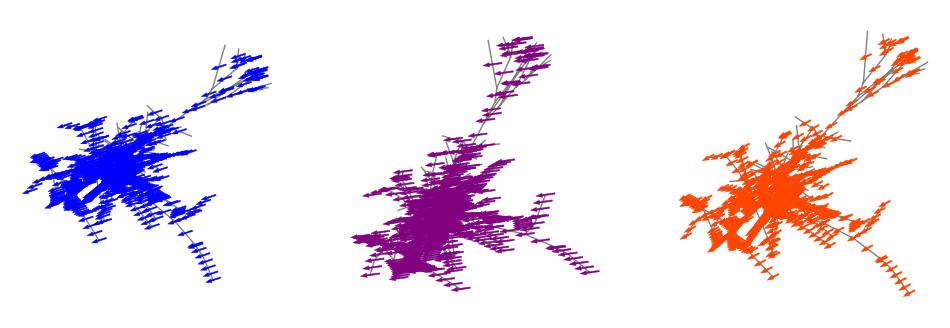

In [37]:
'''non-uniform Efields'''
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
Evec_scale = 3
colors = ['blue', 'purple', 'orangered'] # '#EA700E'
for i in range(len(indices)):
    cell_coordinates = Layer5_popPosition[indices[i]]
    sectionCoords = sectionCoords_allCells[indices[i]]
    Einterp_section = popCell_Einterp_section[indices[i]]
    ax[i].plot(cell_coordinates[0], cell_coordinates[2], lw=1, color='gray', zorder=-5)
    for j in range(sectionCoords.shape[0]):
        x, y = sectionCoords[j][0], sectionCoords[j][2]
        dx, dy = Einterp_section[i][0]/Evec_scale, Einterp_section[i][2]/Evec_scale
        ax[i].arrow(x-0.5*dx, y-0.5*dy, dx, dy, color=colors[i], lw=0.3, alpha=1, \
             width=9e-3, length_includes_head=True )
    ax[i].invert_xaxis()
    ax[i].axis('equal')
    ax[i].axis('off')

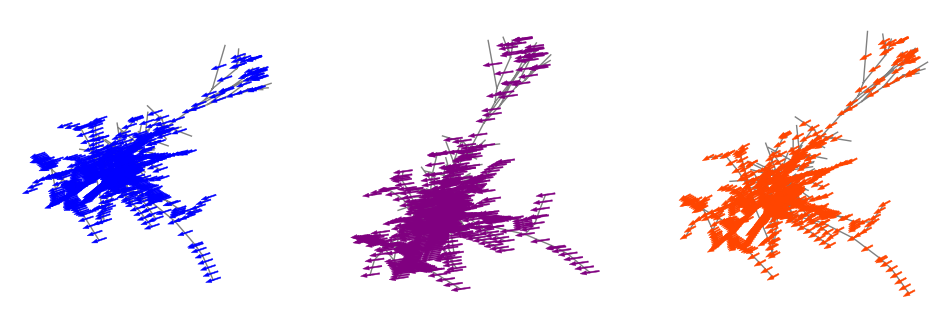

In [40]:
'''uniform Efields'''
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
Evec_scale = 3
colors = ['blue', 'purple', 'orangered'] # '#EA700E'
for i in range(len(indices)):
    cell_coordinates = Layer5_popPosition[indices[i]]
    sectionCoords = sectionCoords_allCells[indices[i]]
    Einterp_section = popCell_Einterp_section[indices[i]]
    Einterp_mean = np.mean(Einterp_section, axis=0)
    ax[i].plot(cell_coordinates[0], cell_coordinates[2], lw=1, color='gray', zorder=-5)
    for j in range(sectionCoords.shape[0]):
        x, y = sectionCoords[j][0], sectionCoords[j][2]
        dx, dy = Einterp_mean[0]/Evec_scale, Einterp_mean[2]/Evec_scale
        ax[i].arrow(x-0.5*dx, y-0.5*dy, dx, dy, color=colors[i], lw=0.3, alpha=1, \
             width=9e-3, length_includes_head=True )
    ax[i].invert_xaxis()
    ax[i].axis('equal')
    ax[i].axis('off')

# 4. Draw the distribution of the uniform electric field on the surface of the L5 ROI.

In [218]:
dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_popCell_interpolate_Evector_forSectionAndSegment.npy'
data = np.load(dataPath, allow_pickle=True).item()
popCell_Einterp_section   = data['popCell_Einterp_section']
popCell_Einterp_segment   = data['popCell_Einterp_segment']
popCell_nearEvector       = data['popCell_nearEvector']
popCell_nearNodes         = data['popCell_nearNodes']
popCell_nearNodes_indices = data['popCell_nearNodes_indices']

dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_popInformation.npy'
data = np.load(dataPath, allow_pickle=True).item()
Layer5_popPosition = data['Layer5_popPosition']

dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_popCell_sectionAndSegmentCoordinates.npy'
popCellInfo = np.load(dataPath, allow_pickle=True).item()
sectionCoords_allCells = popCellInfo['popCells_section_coords']['section_coordinates_mid'] # shape = (num_elem, num_section, 3) = (1000,  780, 3)
segmentCoords_allCells = popCellInfo['popCells_segment_coords']['segment_coordinates_mid'] # shape = (num_elem, num_segment, 3) = (1000, 1808, 3)
cell_normals = popCellInfo['cell_normals']
cell_origins = popCellInfo['cell_origins']

dataPath = r'C:\Users\Snowp\PycharmProjects\pythonProject\24_tACS_PLV\data\Layer5_information_after_downsampling.npy'
surfdata = np.load(dataPath, allow_pickle=True).item()
faces    = surfdata['surface']['faces'] - 1
vertices = surfdata['surface']['vertices']
num_element = surfdata['num_elem']

Efield mean/min/max value: 0.268, 0.143, 0.498 V/m.


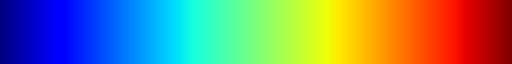

In [220]:
uniformEvector_by_soma = np.zeros((num_element, 3))
for i in range(num_element):
    uniformEvector_by_soma[i, :] = popCell_Einterp_section[i][0, :]
uniformEvector_by_soma_norm = np.linalg.norm(uniformEvector_by_soma, axis=1)
sorted_indices = np.argsort(uniformEvector_by_soma_norm)
print('Efield mean/min/max value: %.3f, %.3f, %.3f V/m.' % (uniformEvector_by_soma_norm.mean(), uniformEvector_by_soma_norm.min(), uniformEvector_by_soma_norm.max()))

value_min, value_max = 0, 0.453
color_numPoint = 5000
value_array    = np.linspace(value_min, value_max, color_numPoint)
cmap           = plt.get_cmap('jet', lut=color_numPoint) # .reversed() 取反
# list_color     = [cmap(i) for i in range(color_numPoint)]
list_color = []
for i in range(num_element):
    if uniformEvector_by_soma_norm[i] >= value_max:
        list_color.append(cmap(-1))
    elif uniformEvector_by_soma_norm[i] <= value_min:
        list_color.append(cmap(0))
    else:    
        diff = np.abs(value_array - uniformEvector_by_soma_norm[i])
        closest_indices = np.argmin(diff)
        list_color.append(cmap(closest_indices))
cmap

Text(0.5, 0.92, 'EF magnitude at the soma (V/m)')

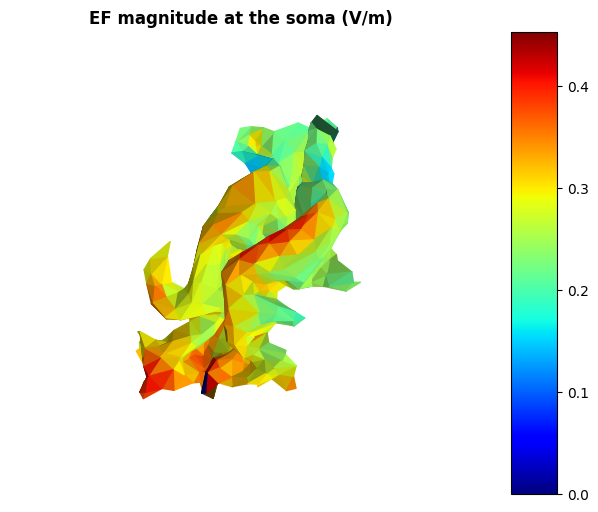

In [221]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(list_color)
fig, ax = plt.subplots(1, 1, figsize=(10, 6), subplot_kw={'projection': '3d'})
polycol3d = Poly3DCollection([vertices[face] for face in faces], facecolors=list_color, edgecolors=list_color, shade=True)
ax.add_collection3d(polycol3d)
ax.set_xlim(-80, 10)
ax.set_ylim(-20, 40)
ax.set_zlim(25, 80)
ax.view_init(45, 180)
ax.axis('off')
ax.axis('equal')
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=value_min, vmax=value_max))
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax, shrink=1, aspect=10, location='right', fraction=0.15)
ax.set_title('EF magnitude at the soma (V/m)', fontsize=12, weight='bold')